In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

from dotenv import load_dotenv


# --- CRITICAL FIX ---
# Define the path to the project root and the .env file.
# This makes the script location-independent and ensures the .env file is found.
project_root = os.getcwd()
env_path = os.path.join(project_root, '.env')

# Now, explicitly load the environment variables from that path.
# load_dotenv(dotenv_path=env_path) <-- Older syntax
load_dotenv(dotenv_path=env_path)
# --- END CRITICAL FIX ---

# Add src directory to Python's path
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path) 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

--- Starting Volatility-Regime Adaptive Portfolio Optimizer ---

--- Phase 1: Data Acquisition ---

--- Phase 2: Market Analysis & Feature Engineering ---
Calculated logarithmic returns for a DataFrame.
Calculated rolling daily volatility over 20 days.
Identified volatility regimes.

--- Phase 3: Strategy Application & Backtesting ---
Generating weights for LOW VOLATILITY regime.
Error during optimization: 'str' object has no attribute 'get'
Generating weights for LOW VOLATILITY regime.
Error during optimization: 'str' object has no attribute 'get'
Generating weights for LOW VOLATILITY regime.
Error during optimization: 'str' object has no attribute 'get'
Generating weights for LOW VOLATILITY regime.
Error during optimization: 'str' object has no attribute 'get'
Generating weights for LOW VOLATILITY regime.
Error during optimization: 'str' object has no attribute 'get'
Generating weights for LOW VOLATILITY regime.
Error during optimization: 'str' object has no attribute 'get'
Generatin

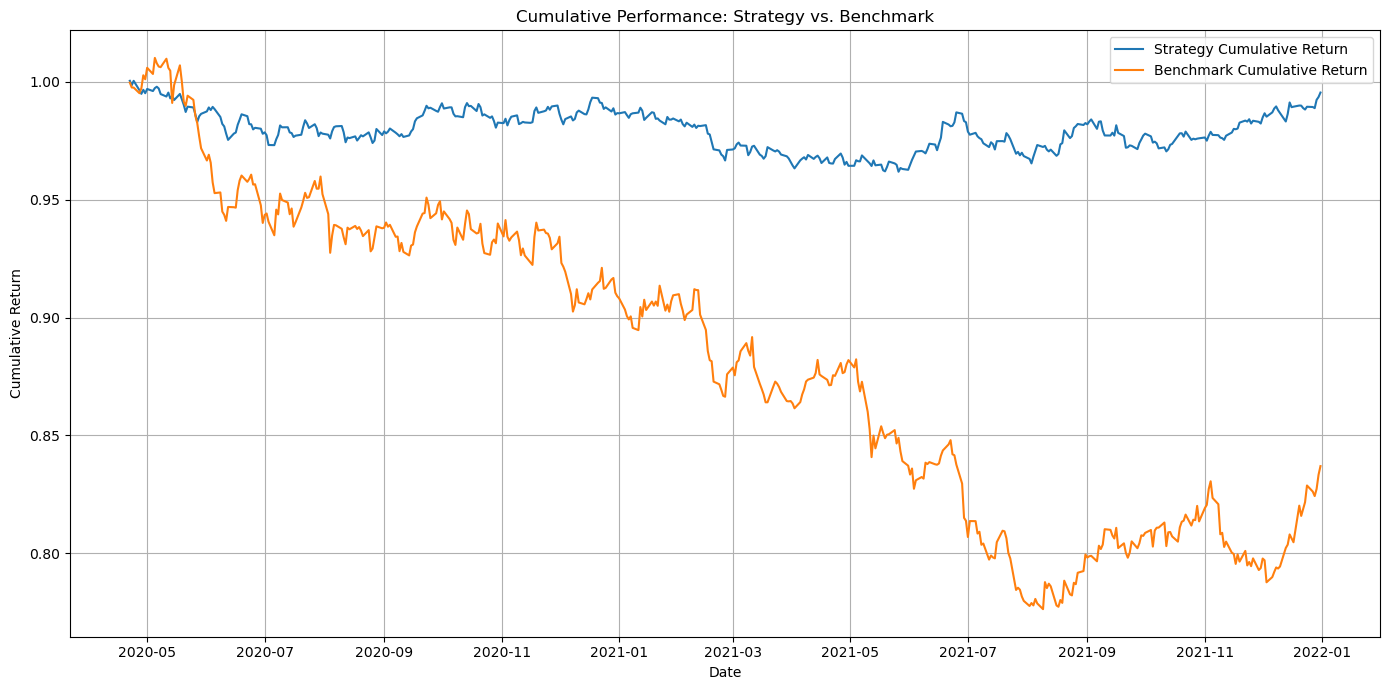

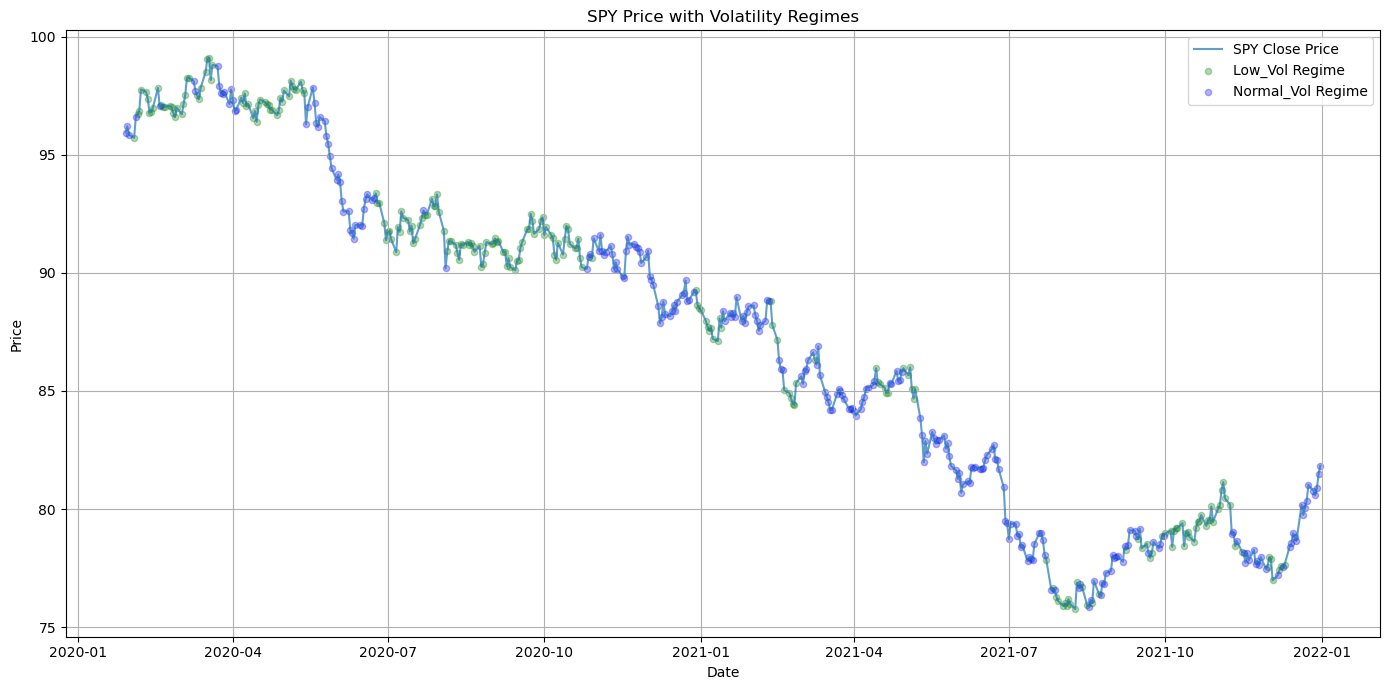

In [3]:
from config import settings
from src.data_fetcher import fetch_multiple_assets_data, save_data, load_data, get_sample_data # Import get_sample_data
from src.market_analyzer import calculate_returns, calculate_volatility, identify_regimes
from src.strategy_engine import generate_regime_specific_weights
from src.backtester import Backtester
from src.metrics_calculator import get_performance_summary, calculate_cumulative_returns

# --- CRITICAL CHANGE ---
# Update the data file path to use a Pickle file for robustness
settings.RAW_DATA_FILE = os.path.join(settings.DATA_DIR, 'raw_market_data.pkl')
# --- END CRITICAL CHANGE ---

# --- Force yfinance for stability ---
settings.FINANCE_API_SOURCE = 'yfinance'

def run_portfolio_optimizer_backtest():
    """
    Orchestrates the data fetching, strategy application, and backtesting.
    """
    print("--- Starting Volatility-Regime Adaptive Portfolio Optimizer ---")

    # 1. Data Acquisition
    print("\n--- Phase 1: Data Acquisition ---")

    df_raw_data = pd.DataFrame()
    
    # === USE THE SAMPLE DATA HERE TO BYPASS THE API ===
    # You can comment out this line and use the API calls below once you've debugged.
    df_raw_data = get_sample_data()

    # if os.path.exists(settings.RAW_DATA_FILE):
    #     df_raw_data = load_data(settings.RAW_DATA_FILE)
    #
    # if df_raw_data.empty:
    #     print("Data is not valid or not found. Forcing a re-fetch of data...")
    #     df_raw_data = fetch_multiple_assets_data(
    #         symbols=settings.ASSET_SYMBOLS,
    #         start_date=settings.START_DATE,
    #         end_date=settings.END_DATE
    #     )
    #     if df_raw_data.empty:
    #         print("Failed to acquire raw data. Exiting.")
    #         return
    #     save_data(df_raw_data, settings.RAW_DATA_FILE)


    min_required_rows = max(settings.VOL_WINDOW, settings.OPTIMIZATION_WINDOW)
    if len(df_raw_data) < min_required_rows:
        print(f"Not enough historical data for the specified windows. Need at least {min_required_rows} rows.")
        return
    
    # 2. Market Analysis & Feature Engineering
    print("\n--- Phase 2: Market Analysis & Feature Engineering ---")

    try:
        df_close_prices = df_raw_data.xs('Close', level=1, axis=1)
    except KeyError:
        print("Warning: 'Close' not found in MultiIndex. This suggests an issue with data loading. Exiting.")
        return
    
    if df_close_prices.empty:
        print("Error: Close price data not found in raw data. Exiting.")
        return
    
    df_asset_returns = calculate_returns(df_close_prices)

    df_volatility = calculate_volatility(df_asset_returns)
    df_market_features = pd.DataFrame(df_volatility, columns=['Volatility'])

    df_market_features['Regime'] = identify_regimes(df_market_features, vol_col='Volatility')
    
    df_features_and_returns = pd.merge(
        df_asset_returns,
        df_market_features[['Regime', 'Volatility']],
        left_index=True, right_index=True,
        how='inner'
    )
    df_features_and_returns = df_features_and_returns.dropna()

    try:
        if settings.ASSET_SYMBOLS[0] in df_close_prices.columns:
            df_benchmark_prices = df_close_prices[settings.ASSET_SYMBOLS[0]]
        else:
            df_benchmark_prices = df_close_prices.mean(axis=1)
            print("Using average of asset prices as benchmark.")
    except KeyError:
        print(f"KeyError while selecting benchmark. Using average of all close prices.")
        df_benchmark_prices = df_close_prices.mean(axis=1)
    
    df_benchmark_prices = df_benchmark_prices.loc[df_features_and_returns.index]

    # 3. Strategy Application & Backtesting
    print("\n--- Phase 3: Strategy Application & Backtesting ---")
    backtester = Backtester(
        initial_capital=settings.INITIAL_CAPITAL,
        transaction_cost_bps=settings.TRANSACTION_COST_BPS,
        slippage_bps=settings.SLIPPAGE_BPS
    )

    optimal_weights_history = []
    
    df_backtest_prices = df_close_prices.loc[df_features_and_returns.index]
    
    backtest_start_index = settings.OPTIMIZATION_WINDOW -1
    
    if backtest_start_index >= len(df_features_and_returns):
        print("Not enough data points after feature engineering for backtesting window.")
        return

    for i in range(backtest_start_index, len(df_features_and_returns)):
        current_date = df_features_and_returns.index[i]
        
        current_regime = df_features_and_returns.loc[current_date, 'Regime']

        lookback_end_date = df_features_and_returns.index[i-1] if i > 0 else current_date
        lookback_start_date = df_features_and_returns.index[i - settings.OPTIMIZATION_WINDOW]
        
        lookback_returns_data = df_asset_returns.loc[lookback_start_date:lookback_end_date]

        optimal_weights = generate_regime_specific_weights(
            current_regime=current_regime,
            lookback_returns=lookback_returns_data
        )
        optimal_weights_history.append({'Date': current_date, **{s: w for s, w in zip(df_asset_returns.columns, optimal_weights)}})
    
    df_weights = pd.DataFrame(optimal_weights_history).set_index('Date')
    df_weights = df_weights.reindex(df_backtest_prices.index)

    portfolio_history_df = backtester.run_backtest(df_backtest_prices, df_weights)

    # 4. Performance Calculation & Summary
    print("\n--- Phase 4: Performance Calculation & Summary ---")
    if portfolio_history_df.empty:
        print("Portfolio history is empty. Cannot calculate performance.")
        return

    benchmark_aligned_prices = df_benchmark_prices.reindex(portfolio_history_df.index).dropna()
    
    performance_summary = get_performance_summary(
        portfolio_history_df['Total_Value'],
        benchmark_aligned_prices,
        risk_free_rate_annual=settings.RISK_FREE_RATE_ANNUAL
    )

    print("\n--- Performance Summary ---")
    for k, v in performance_summary.items():
        if isinstance(v, (float, np.float64)):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    # 5. Visualization (Basic plots here, dashboard in app/)
    print("\n--- Phase 5: Visualization ---")

    plt.figure(figsize=(14, 7))
    plt.plot(calculate_cumulative_returns(calculate_returns(portfolio_history_df['Total_Value'])), label='Strategy Cumulative Return')
    plt.plot(calculate_cumulative_returns(calculate_returns(benchmark_aligned_prices)), label='Benchmark Cumulative Return')
    plt.title('Cumulative Performance: Strategy vs. Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    main_asset_prices = df_close_prices[settings.ASSET_SYMBOLS[0]].loc[df_features_and_returns.index]
    
    plt.plot(main_asset_prices, label=f'{settings.ASSET_SYMBOLS[0]} Close Price', alpha=0.7)
    
    regime_colors = {'Low_Vol': 'green', 'Normal_Vol': 'blue', 'High_Vol': 'red'}
    for regime, color in regime_colors.items():
        regime_dates = df_market_features.index[df_market_features['Regime'] == regime]
        regime_dates = regime_dates[regime_dates.isin(main_asset_prices.index)]
        if not regime_dates.empty:
            plt.scatter(regime_dates, main_asset_prices.loc[regime_dates],
                        color=color, label=f'{regime} Regime', alpha=0.3, s=20)
    
    plt.title(f'{settings.ASSET_SYMBOLS[0]} Price with Volatility Regimes')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_portfolio_optimizer_backtest()